# 
Task 2



# Import packages

In [0]:
from fastai import *
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [0]:
import pandas as pd
import itertools
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit, StratifiedKFold
import numpy as np
from scipy import stats 
from scipy.special import boxcox1p
import re
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler, Binarizer

pd.set_option('display.max_columns', None)

# Functions

In [0]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe:         
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def make_real_feature(df, name, group_col='userid'):
    """
    вычисление разных статистик
    """
    tmp = df.groupby(group_col)[name].agg({np.mean, max, min, np.median, sum, np.var}).fillna(-1)
    tmp.columns = [name + '_' + str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    return (tmp[tmp.columns[tmp.nunique()>1]])

def make_harmonic_features(df, column):
    """
    преобразование периодических признаков
    """
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value)
        df[col + '_sin'] = np.sin(value)
    return (df)

SEED=17

In [130]:
df_train = pd.read_csv('onetwotrip_challenge_train.csv')
df = downcast_dtypes(df_train)
del df_train
gc.collect()

cols_to_rename = {'field0': 'days_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_depart',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'};

df.rename(columns=cols_to_rename, inplace=True)
df.shape

(196056, 43)

PREPROCESSING

In [131]:
df['unq'] = df.userid.map(df.groupby('userid').size())
df['order_of_buy_invert'] = df.unq-df.order_of_buy

df['diff_month'] = (df.month_depart - df.month_buy)
df['diff_hour'] = df.field23 - df.hour_depart
df.shape

(196056, 47)

In [132]:
periodical_feats = ['month_buy', 'month_depart', 
                    'hour_depart', 'dow_buy', 'dow_depart', 'quarter', 'field27', 'field23']

df_new = make_harmonic_features(df, periodical_feats).copy()

# to_drop = ['orderid', 'userid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']# + periodical_feats

# df_new.drop(columns=to_drop, axis=1, inplace=True)

# проверка на пропущенные значения
assert df_new.isnull().sum().sum()==0

# оптимизация типа значений
df_train = downcast_dtypes(df_new)
del df_new
gc.collect()

df_train.shape

(196056, 63)

# Train test split

In [133]:
train, test = train_test_split(df_train, stratify=df_train['goal1'], random_state=SEED)

print(f"shape train: {train.shape}, shape test: {test.shape}")
print(f"percent of target: train={train.goal1.sum()/len(train)},\
        test={test.goal1.sum()/len(test)}")

shape train: (147042, 63), shape test: (49014, 63)
percent of target: train=0.022143333197317774,        test=0.02213653241930877


In [0]:
# подготовка для теста
drop_col_test = ['goal1']
y_test = test.goal1.copy()
X_test = test.drop(columns=drop_col_test, axis=1)

In [91]:
len(train)/1024

143.595703125

# fastai model

In [0]:
cols_cos_sin = list(filter(lambda x: ('cos' in x) | ('sin' in x) , train.columns))

procs = [Categorify, Normalize]
cat_names = ['field5', 'field7', 'field8','field10', 'field19', 'year', 'indicator_goal21', 
             'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25'] + periodical_feats

cont_names = ['days_from_last', 'order_of_buy', 'field1', 'field6', 'field12', 'field13', 'field14', 
              'total_tickets', 'days_before_depart', 'field17', 'field22', 'field25', 'field26', 
              'ticket_child_4y', 'ticket_child_1y', 'ticket_adult', 'unq', 'order_of_buy_invert',
              'diff_month', 'diff_hour'] + cols_cos_sin

dep_var = 'goal1'

In [115]:
data = (TabularList.from_df(train, procs=procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx=range(int(len(train)*0.9), len(train)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(X_test, cat_names=cat_names, cont_names=cont_names, procs=procs))
        .databunch(bs=2500))

print('Continuous feats: ', data.train_ds.cont_names)
print('Categorical feats: ', data.train_ds.cat_names)

Continuous feats:  ['days_from_last', 'order_of_buy', 'field1', 'field6', 'field12', 'field13', 'field14', 'total_tickets', 'days_before_depart', 'field17', 'field22', 'field25', 'field26', 'ticket_child_4y', 'ticket_child_1y', 'ticket_adult', 'unq', 'order_of_buy_invert', 'diff_month', 'diff_hour', 'month_buy_cos', 'month_buy_sin', 'month_depart_cos', 'month_depart_sin', 'hour_depart_cos', 'hour_depart_sin', 'dow_buy_cos', 'dow_buy_sin', 'dow_depart_cos', 'dow_depart_sin', 'quarter_cos', 'quarter_sin', 'field27_cos', 'field27_sin', 'field23_cos', 'field23_sin']
Categorical feats:  ['field5', 'field7', 'field8', 'field10', 'field19', 'year', 'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']


In [0]:
assert len(data.train_ds.cont_names) == len(data.test_ds.cont_names)
assert len(data.train_ds.cat_names) == len(data.test_ds.cat_names)

In [0]:
learn = tabular_learner(data, layers=[1000, 500], metrics=AUROC(), callback_fns=[ShowGraph, SaveModelCallback])

epoch,train_loss,valid_loss,auroc,time
0,0.447765,0.103888,0.603560,00:08
1,0.212858,0.103404,0.607568,00:08
2,0.150471,0.100290,0.616982,00:08
3,0.121062,0.099441,0.660209,00:07
4,0.110760,0.098148,0.649432,00:07
5,0.106038,0.100045,0.665972,00:08
6,0.105000,0.100001,0.658934,00:07
7,0.104038,0.098883,0.657229,00:07
8,0.100899,0.098003,0.664068,00:07
9,0.098589,0.097969,0.667600,00:07


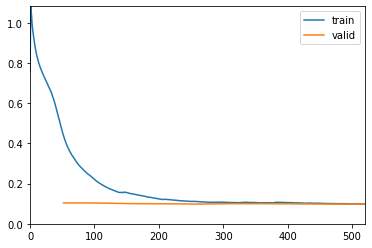

Better model found at epoch 0 with valid_loss value: 0.10388781130313873.
Better model found at epoch 1 with valid_loss value: 0.10340363532304764.
Better model found at epoch 2 with valid_loss value: 0.10029014945030212.
Better model found at epoch 3 with valid_loss value: 0.09944100677967072.
Better model found at epoch 4 with valid_loss value: 0.09814808517694473.
Better model found at epoch 8 with valid_loss value: 0.0980026051402092.
Better model found at epoch 9 with valid_loss value: 0.09796871989965439.


In [118]:
learn.fit_one_cycle(10, 2.5e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


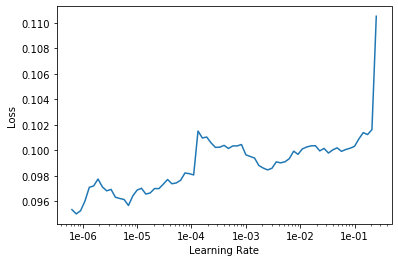

In [119]:
learn.lr_find()
learn.recorder.plot()

In [120]:
def auc_score(y_score, y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))
    
probs, val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
# print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

AUC tensor(0.6676)


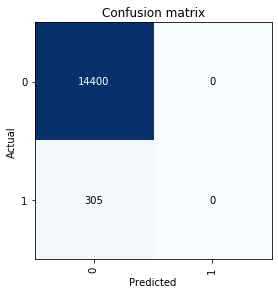

In [121]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

epoch,train_loss,valid_loss,auroc,time
0,0.096750,0.097950,0.667752,00:08
1,0.097321,0.097946,0.667915,00:08
2,0.097346,0.098035,0.667824,00:07
3,0.097163,0.097912,0.667758,00:08
4,0.099367,0.097913,0.667768,00:07
5,0.098003,0.098671,0.667365,00:07
6,0.097584,0.098145,0.667285,00:07
7,0.097518,0.099240,0.667017,00:08
8,0.096974,0.099537,0.667297,00:08
9,0.097216,0.098157,0.667445,00:07


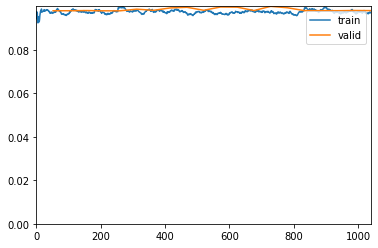

Better model found at epoch 0 with valid_loss value: 0.09794967621564865.
Better model found at epoch 1 with valid_loss value: 0.09794627130031586.
Better model found at epoch 3 with valid_loss value: 0.0979115292429924.


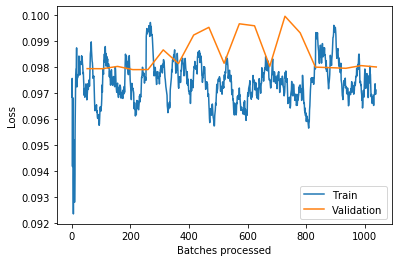

In [122]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-06))

# Analyse our model
learn.model
learn.recorder.plot_losses()

In [123]:
preds, val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('AUC', auc_score(preds, val_labels))

AUC tensor(0.6678)


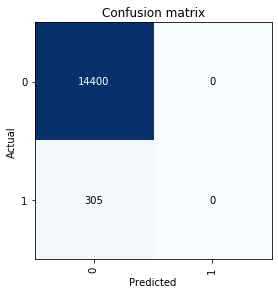

In [124]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [97]:
preds.max(1)

torch.return_types.max(values=tensor([0.9937, 0.9942, 0.9733,  ..., 0.9976, 0.9875, 0.9896]), indices=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [0]:
# dt_train = {'orderid': np.uint32, 'userid': object, 'field0': np.uint16, 
#          'field1': np.float32, 'field2': 'category', 'field3': 'category' , 
#          'field4': np.uint16, 'field5': 'category', 'field6': np.uint16, 
#          'field7': 'category', 'field8': 'category', 'field9': 'category', 
#          'field10': 'category', 'field11': 'category', 'field12': np.uint16, 
#          'field13': np.uint16, 'field14': np.float16, 'field15': np.uint8, 
#          'field16': np.uint16, 'field17': np.uint16, 'field18': 'category',
#          'field19': np.uint16, 'field20': 'category', 'field21': 'category',
#          'field22': np.uint16, 'field23': 'category', 'field24': np.uint16,
#          'field25': np.uint16, 'field26': np.uint16, 'field27': 'category',
#          'field28': np.uint16, 'field29': 'category', 'indicator_goal21': 'category',
#          'indicator_goal22': 'category', 'indicator_goal23': 'category', 'indicator_goal24': 'category',
#          'indicator_goal25': 'category', 'goal21': 'category', 'goal22': 'category', 'goal23': 'category',
#          'goal24': 'category', 'goal25': 'category', 'goal1': 'category'}

# dt_test = dict(itertools.islice(dt_train.items(), 37))

# df = pd.read_csv('onetwotrip_challenge_train.csv', usecols=dt_train.keys(), dtype=dt_train)
# dft = pd.read_csv('onetwotrip_challenge_test.csv', usecols=dt_test.keys(), dtype=dt_test)

# th=df.shape[0]
# print('Size of train: ', df.shape)
# print('Size of test: ', dft.shape)

Size of train:  (196056, 43)
Size of test:  (455011, 37)


In [0]:
dfall = pd.concat([df[dft.columns], dft], axis=0)
del dft
dfall.shape

(651067, 37)

In [0]:
# Categorical

# frequency encoding
fencoding = dfall.groupby('userid').size()
# fencoding = (fencoding - fencoding.min()) / (fencoding.max()-fencoding.min())
dfall['user_enc'] = dfall.userid.map(fencoding)

# конкатенация
# dfall['f11_27'] = dfall['field11'].astype('str') + '_' + dfall['field27'].astype('str')
# dfall['f11_27'] = dfall['f11_27'].astype('category').cat.codes

# бинаризируем периоды
bin_d={'field11': ['1', '2', '3', '4', '5', '6', '7'], 
        'field3': ['2', '3', '4', '5'],
        'field19': ['1', '2', '3', '4', '5'],
        'field2': ['1', '2', '3', '4', '5'], 
        'field27': ['1', '3']}

In [0]:
# Real numbers

# бинаризируем от нуля
binarizer = Binarizer().fit(dfall[['field1', 'field14']])
xbin=binarizer.transform(dfall[['field1', 'field14']])
dfall.join(pd.DataFrame(xbin.astype('int'), columns=['bin_1', 'bin_14']))


# Box Cox Transformation of (highly) skewed features
num_col = dfall.select_dtypes('float').columns
skewed_feats = dfall[num_col].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print(f"There are {skewness.shape[0]} skewed numerical features to Box Cox transform {skewness.index}")
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    dfall[feat] = boxcox1p(dfall[feat], lam)


Skew in numerical features: 

There are 0 skewed numerical features to Box Cox transform Index([], dtype='object')


In [0]:
# Normalize count of available indicators
dfall['indicator_cnt'] = dfall[list(filter(lambda x: 'indicator' in x, dfall.columns))]\
                         .apply(lambda x: np.sum(x.astype(np.uint8)), axis=1).astype(np.uint8)

In [0]:
# Train test split
train = dfall[:th].copy()
test = dfall[th:].copy()

del dfall

In [0]:
train = train.join(df.goal1)

# Import

In [126]:
!pip install -U h2o

     |████████████████████████████████| 123.7MB 96kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.11-py2.py3-none-any.whl size=123721708 sha256=954234042c7eb2c44e855fef17013c22dad302835e2f9034007dcbe63a09f8a7
  Stored in directory: /root/.cache/pip/wheels/71/e6/ed/fb9be80ae2eb0bef9deada74fc370b2532f578d8b00bc1a8fb
Successfully built h2o


In [0]:
import h2o
from h2o.automl import H2OAutoML

In [0]:
# h2o.cluster().show_status()

In [129]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkiwdptia
  JVM stdout: /tmp/tmpkiwdptia/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkiwdptia/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.11
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_unknownUser_6nsvue
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
# train = h2o.import_file('onetwotrip_challenge_train.csv')
# test = h2o.import_file('ottrip/onetwotrip_challenge_test.csv')

# train = h2o.import_file('train1.csv')
# test = h2o.import_file('test1.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train.head()

field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,user_enc,f11_27,f_11,f_3,f_19,f_2,f_27,indicator_cnt,goal1
0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0.624448,161,0,0,0,0,1,0.8,0
144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0.624936,91,0,0,0,1,1,0.6,0
134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0.624936,153,1,1,0,1,0,0.8,0
0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.5215,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0.625423,70,0,0,0,0,1,0.8,0
0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.8013,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0.624448,49,0,0,0,0,1,0.6,0
0,-0.316223,9,9,1,1,0,1,1,0,0,10,5,62,-0.5215,2,0,1,6,5,6,1,1,17,1,1,1,1,1,3,1,1,0,0,0,0.625423,7,0,0,0,0,1,0.4,0
0,0.0716341,10,10,1,1,0,1,1,0,0,7,3,2,0.599,1,6,1,4,2,3,1,22,5,1,1,1,1,0,4,1,1,1,1,1,0.624448,147,1,0,0,0,1,1,0
0,-0.238651,10,11,1,1,1,1,1,0,1,10,9,4,0.03903,1,22,1,5,2,6,1,44,21,1,1,7,5,0,4,1,1,1,1,0,0.624448,11,0,0,0,0,0,0.8,0
0,-0.00593723,8,8,1,1,0,1,1,0,1,14,9,3,-0.2411,2,1,1,1,1,2,1,21,9,2,1,1,1,0,3,1,1,1,0,1,0.624936,35,0,0,0,0,1,0.8,0
156,1.62306,2,2,3,0,6,2,0,0,1,19,9,92,1.159,2,2,1,5,2,7,2,46,12,2,18,12,3,0,1,1,1,0,0,0,0.625423,72,0,1,0,1,1,0.4,0


In [0]:
# y = "class"  2
# x = data.names
# x.remove(y)
# train, test = data.split_frame([0.8])

# m = h2o.estimators.deeplearning.H2ODeepLearningEstimator() 
# m.train(x, y, train)
# p = m.predict(test) 

# Train


In [136]:
to_drop_test = ['orderid', 'userid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25', 'goal1']
to_drop

['orderid', 'userid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']

In [144]:
#drop order from test set

# train = train.drop(['orderid', 'userid'],axis =1)
# test = test.drop(['orderid', 'userid'],axis =1)

htrain = h2o.H2OFrame(train)
htest = h2o.H2OFrame(test)
orderid = htest['orderid']

htrain = htrain.drop(to_drop, axis =1)
htest = htest.drop(to_drop, axis =1)

# orderid = np.arange(test.shape[0])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Identify predictors and response
x = htrain.columns
y = 'goal1'
x.remove(y)

# tr, val = train.split_frame(ratios=[0.8], seed = 17)

In [0]:
#for binary classification, lables should be a factor
htrain[y] = htrain[y].asfactor()

In [140]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=15, balance_classes=True, stopping_metric="AUC",
                stopping_rounds = 3, stopping_tolerance = 1e-2, seed=17)

aml.train(x=x, y=y, training_frame=htrain)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [141]:
# View the AutoML Leaderboard 3
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191215_194137,0.679715,0.102126,0.441938,0.146323,0.0214106
StackedEnsemble_BestOfFamily_AutoML_20191215_194137,0.678074,0.102789,0.44682,0.147125,0.0216457
GBM_1_AutoML_20191215_194137,0.669343,0.102557,0.442296,0.146525,0.0214696
GLM_grid_1_AutoML_20191215_194137_model_1,0.666976,0.102501,0.426608,0.146594,0.0214898
GBM_2_AutoML_20191215_194137,0.659478,0.103343,0.431614,0.146632,0.0215011
XGBoost_2_AutoML_20191215_194137,0.648696,0.110019,0.429386,0.148213,0.0219671
GBM_3_AutoML_20191215_194137,0.641689,0.104755,0.441221,0.146788,0.0215468
DeepLearning_1_AutoML_20191215_194137,0.633407,0.107395,0.451013,0.149155,0.0222472
GBM_5_AutoML_20191215_194137,0.63173,0.115813,0.455336,0.147514,0.0217605
XGBoost_1_AutoML_20191215_194137,0.629181,0.111391,0.444162,0.148661,0.0221001


In [0]:
# View the AutoML Leaderboard 3
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191128_172451,0.688571,0.101435,0.440677,0.146118,0.0213504
StackedEnsemble_BestOfFamily_AutoML_20191128_172451,0.685537,0.102533,0.440102,0.147244,0.0216809
GBM_1_AutoML_20191128_172451,0.679623,0.101854,0.434642,0.146395,0.0214315
GBM_2_AutoML_20191128_172451,0.672138,0.102329,0.442158,0.146453,0.0214486
XGBoost_2_AutoML_20191128_172451,0.665167,0.11091,0.433676,0.148333,0.0220027
GLM_grid_1_AutoML_20191128_172451_model_1,0.663965,0.10261,0.452335,0.146607,0.0214936
GBM_3_AutoML_20191128_172451,0.658926,0.103419,0.441393,0.146615,0.0214961
XGBoost_1_AutoML_20191128_172451,0.65433,0.108549,0.429707,0.147716,0.0218199
XGBoost_3_AutoML_20191128_172451,0.640755,0.113909,0.446131,0.149118,0.0222362
GBM_5_AutoML_20191128_172451,0.638805,0.112572,0.451043,0.147286,0.0216931


In [0]:
# View the AutoML Leaderboard 2
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191128_143349,0.686405,0.101468,0.437202,0.146087,0.0213413
StackedEnsemble_BestOfFamily_AutoML_20191128_143349,0.683421,0.102518,0.444828,0.147211,0.0216712
GBM_1_AutoML_20191128_143349,0.677035,0.101985,0.434636,0.146411,0.0214361
GBM_2_AutoML_20191128_143349,0.667827,0.102598,0.44845,0.146485,0.0214578
XGBoost_1_AutoML_20191128_143349,0.666506,0.106287,0.435643,0.147122,0.021645
GLM_grid_1_AutoML_20191128_143349_model_1,0.664816,0.102574,0.424277,0.146605,0.0214931
XGBoost_3_AutoML_20191128_143349,0.66184,0.116138,0.43981,0.149741,0.0224222
XGBoost_2_AutoML_20191128_143349,0.659864,0.105736,0.424704,0.147065,0.021628
GBM_3_AutoML_20191128_143349,0.659488,0.103359,0.445164,0.146587,0.0214879
GBM_5_AutoML_20191128_143349,0.637727,0.112533,0.444634,0.147284,0.0216925


In [142]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191215_194137

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.008683724386372164
RMSE: 0.0931865032414682
LogLoss: 0.044665593186255584
Null degrees of freedom: 147041
Residual degrees of freedom: 147031
Null deviance: 31251.508071701413
Residual deviance: 13135.436306586787
AIC: 13157.436306586787
AUC: 0.9941518480866887
pr_auc: 0.8781432419347044
Gini: 0.9883036961733773

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1539531668746573: 


,,0,1,Error,Rate
0,0,143583.0,203.0,0.0014,(203.0/143786.0)
1,1,741.0,2515.0,0.2276,(741.0/3256.0)
2,Total,144324.0,2718.0,0.0064,(944.0/147042.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153953,0.841982,222.0
1,max f2,0.094794,0.829455,252.0
2,max f0point5,0.205946,0.904822,204.0
3,max accuracy,0.168241,0.993607,216.0
4,max precision,0.999755,1.000000,0.0
5,max recall,0.022026,1.000000,349.0
6,max specificity,0.999755,1.000000,0.0
7,max absolute_mcc,0.153953,0.842298,222.0
8,max min_per_class_accuracy,0.046847,0.956695,298.0
9,max mean_per_class_accuracy,0.046118,0.958195,299.0



Gains/Lift Table: Avg response rate:  2.21 %, avg score:  3.21 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.547158,45.098919,45.098919,0.998640,0.848817,0.998640,0.848817,0.451167,0.451167,4409.891857,4409.891857
1,,2,0.020001,0.130242,34.469305,39.785919,0.763265,0.280687,0.880993,0.564849,0.344595,0.795762,3346.930502,3878.591894
2,,3,0.030005,0.078417,8.718920,29.427905,0.193066,0.098158,0.651632,0.409250,0.087224,0.882985,771.891959,2842.790533
3,,4,0.040002,0.061918,3.963048,23.063856,0.087755,0.069042,0.510711,0.324227,0.039619,0.922604,296.304844,2206.385575
4,,5,0.050006,0.052997,1.934127,18.836760,0.042828,0.057111,0.417109,0.270789,0.019349,0.941953,93.412653,1783.676046
5,,6,0.100005,0.035601,0.841535,9.839759,0.018634,0.042499,0.217885,0.156652,0.042076,0.984029,-15.846521,883.975950
6,,7,0.150005,0.029070,0.214991,6.631649,0.004761,0.031973,0.146847,0.115094,0.010749,0.994779,-78.500936,563.164866
7,,8,0.200004,0.025522,0.055283,4.987613,0.001224,0.027135,0.110442,0.093105,0.002764,0.997543,-94.471669,398.761323
8,,9,0.300003,0.021600,0.024570,3.333303,0.000544,0.023336,0.073810,0.069849,0.002457,1.000000,-97.542964,233.330311
9,,10,0.400001,0.019262,0.000000,2.499991,0.000000,0.020347,0.055358,0.057474,0.000000,1.000000,-100.000000,149.999150




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.02141056383402092
RMSE: 0.14632349036986822
LogLoss: 0.10212630895949855
Null degrees of freedom: 147041
Residual degrees of freedom: 147031
Null deviance: 31253.273261839444
Residual deviance: 30033.713444045166
AIC: 30055.713444045166
AUC: 0.6797154918681876
pr_auc: 0.05266070162341076
Gini: 0.35943098373637516

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04397771521810446: 


,,0,1,Error,Rate
0,0,136504.0,7282.0,0.0506,(7282.0/143786.0)
1,1,2713.0,543.0,0.8332,(2713.0/3256.0)
2,Total,139217.0,7825.0,0.068,(9995.0/147042.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.043978,0.098006,219.0
1,max f2,0.025579,0.161852,289.0
2,max f0point5,0.056371,0.084874,188.0
3,max accuracy,0.751359,0.977938,12.0
4,max precision,0.999344,1.000000,0.0
5,max recall,0.010759,1.000000,398.0
6,max specificity,0.999344,1.000000,0.0
7,max absolute_mcc,0.032499,0.083443,257.0
8,max min_per_class_accuracy,0.019950,0.627457,323.0
9,max mean_per_class_accuracy,0.019446,0.630638,327.0



Gains/Lift Table: Avg response rate:  2.21 %, avg score:  2.21 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.087424,4.113856,4.113856,0.091094,0.144696,0.091094,0.144696,0.041155,0.041155,311.385642,311.385642
1,,2,0.020001,0.065587,3.502229,3.808147,0.077551,0.074758,0.084325,0.109739,0.035012,0.076167,250.222885,280.814662
2,,3,0.030005,0.055725,3.223544,3.613235,0.071380,0.060280,0.080009,0.093249,0.032248,0.108415,222.354421,261.323498
3,,4,0.040002,0.049500,2.365541,3.301417,0.052381,0.052401,0.073104,0.083040,0.023649,0.132064,136.554054,230.141743
4,,5,0.050006,0.044952,2.486734,3.138436,0.055065,0.047098,0.069495,0.075850,0.024877,0.156941,148.673411,213.843645
5,,6,0.100005,0.033641,2.137621,2.638063,0.047334,0.038405,0.058416,0.057128,0.106880,0.263821,113.762121,163.806286
6,,7,0.150005,0.028403,1.627786,2.301319,0.036045,0.030740,0.050959,0.048333,0.081388,0.345209,62.778627,130.131926
7,,8,0.200004,0.025316,1.468079,2.093016,0.032508,0.026743,0.046346,0.042936,0.073403,0.418612,46.807894,109.301627
8,,9,0.300003,0.021709,1.280730,1.822260,0.028360,0.023353,0.040351,0.036408,0.128071,0.546683,28.072995,82.226030
9,,10,0.400001,0.019382,1.090310,1.639276,0.024143,0.020473,0.036299,0.032425,0.109029,0.655713,9.030967,63.927575


In [0]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly
# preds = aml.predict(val)
# # or:
# preds_leader = aml.leader.predict(val)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
xtest = htest.columns
ytest = 'goal1'
xtest.remove(ytest)

In [148]:
pred = aml.leader.predict(xtest)

ValueError: ignored

In [0]:
pred = aml.leader.predict(htest)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
pred

predict,p0,p1
0,0.987795,0.0122049
0,0.987919,0.0120808
0,0.971605,0.0283948
0,0.975712,0.0242881
0,0.989408,0.0105924
0,0.986147,0.0138534
0,0.986612,0.0133883
0,0.982519,0.0174815
0,0.97643,0.0235699
0,0.984704,0.0152955


In [0]:
pred_df = pred.as_data_frame()
pred_res = pred_df.p1
orderid_df = orderid.as_data_frame()
# orderid_df = pd.DataFrame({'orderid': orderid})
res = pd.concat([orderid_df,pred_res],axis=1, ignore_index = True)
res.columns = ['orderid','proba']


In [0]:
res.to_csv('pred_2.csv', index=False)

In [0]:
res

,orderid,proba
0,0,0.012205
1,1,0.012081
2,2,0.028395
3,3,0.024288
4,4,0.010592
...,...,...
455006,455006,0.053199
455007,455007,0.020995
455008,455008,0.016173
455009,455009,0.040752
